In [53]:
# Setup
import matplotlib
import numpy as np
import scipy as sp
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import pandas as pd
from ggplot import * #I'm sorry
%matplotlib inline

In [7]:
# Start an inference server

from venture.shortcuts import *
v = make_church_prime_ripl()
# x = Puma().make_church_prime_ripl()

In [8]:
# Forget everything

v.clear()

In [9]:
# # Specify model 1

# v.assume("offset_1", "(uniform_continuous -1 1)")
# v.assume("offset_2", "(uniform_continuous -1 1)")
# v.assume("linear", "(flip 0.5)")
# v.assume("beta_1", "(if linear (uniform_continuous -1 1) 0)")
# v.assume("quadratic", "(flip 0.5)")
# v.assume("beta_2", "(if quadratic (uniform_continuous -1 1) 0)")
# v.assume("noise_sd", "(exp (normal 0 2))")

# v.assume("f_1", "(lambda (x) (+ offset_1 (* beta_1 x) (* beta_2 x x)))")
# v.assume("f_2", "(lambda (x) (+ offset_2 (* beta_1 x) (* beta_2 x x)))")

# v.assume("cluster_membership", "(mem (lambda (index) (if (flip) 1 2)))")

# v.assume("f", "(lambda (x index) (if (eq (cluster_membership index) 1) (f_1 x) (f_2 x)))")

In [10]:
# Specify model 2

# v.assume("cluster_membership_crp", "(make_sym_dir_mult 1 2)")
v.assume("cluster_membership_crp", "(make_crp 0.3)")
v.assume("cluster_membership", "(mem (lambda (index) (cluster_membership_crp)))")
# v.assume("cluster_membership", "(mem (lambda (index) (if (flip) 0 1)))")

v.assume("offset", "(mem (lambda (cluster_index) (uniform_continuous -1 1)))")
v.assume("beta", "(uniform_continuous -1 1)")
v.assume("noise_sd", "(+ 0.1 (exp (normal 0 2)))")

v.assume("f", "(lambda (x index) (+ (offset (cluster_membership index)) (* beta x)))")

'<procedure>'

In [11]:
v.sample('(cluster_membership 0)')

1

In [12]:
# Start inference

# v.start_continuous_inference()

In [13]:
# Create data

X_1 = np.linspace(0, 1, 10)
Y_1 = -0.2 + 0.5 * X_1 + 0.0 * X_1 * X_1
Y_1 += 0.1 * np.random.randn(*X_1.shape)

X_2 = np.linspace(0, 1, 15)
Y_2 = +0.2 + 0.5 * X_2
Y_2 += 0.1 * np.random.randn(*X_2.shape)

X_3 = np.linspace(0, 1, 5)
Y_3 = +0.7 + 0.5 * X_3
Y_3 += 0.1 * np.random.randn(*X_3.shape)

X = np.concatenate((X_1, X_2, X_3))
Y = np.concatenate((Y_1, Y_2, Y_3))

In [14]:
# Observe data

for index, (x, y) in enumerate(zip(X, Y)):
    v.observe("(normal (f %f %d) noise_sd)" % (x, index), y)
    index += 1

In [15]:
# v.sample("(cluster_membership 0)")

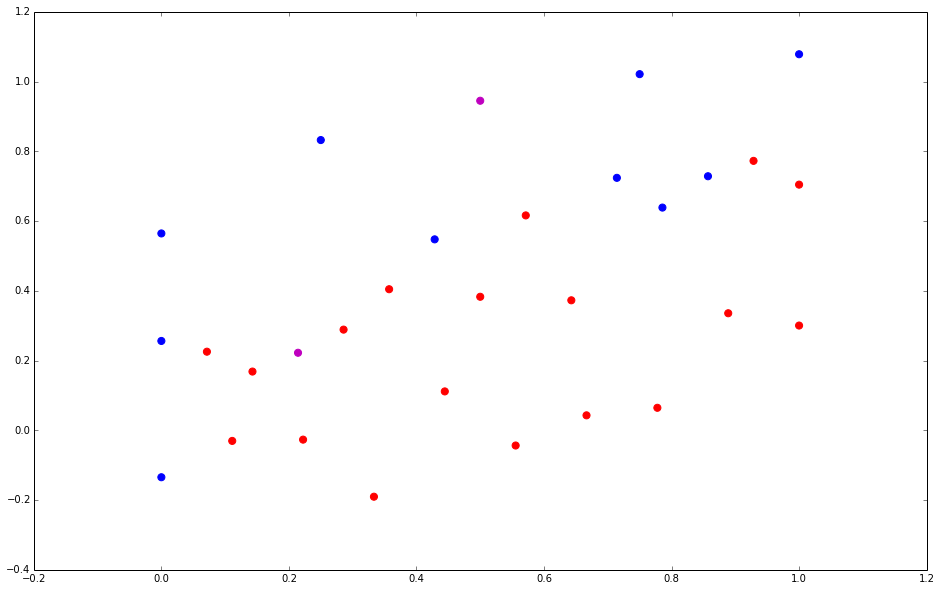

In [26]:
# Sample the parameters and draw a picture

# Only necessary if not running continuous inference
v.infer(5000)

# sample = v.sample("(list offset_1 offset_2 beta_1 beta_2 noise_sd)")
# offset_1 = sample[0]
# offset_2 = sample[1]
# beta_1 = sample[2]
# beta_2 = sample[3]
# noise_sd = sample[4]

# beta = v.sample("beta_1")
# offset_1 = v.sample("(offset 0)")
# offset_2 = v.sample("(offset 1)")

fig, ax = plt.subplots(figsize=(16, 10))
plt.clf()

cluster_memberships = v.sample('(list ' + ' '.join('(cluster_membership %d)' % index
                                                   for index in range(len(X))) + ')')
cluster_numbers = np.unique(cluster_memberships)
canonical_cluster_memberships = np.zeros(len(cluster_memberships))
for i, value in enumerate(cluster_numbers):
    canonical_cluster_memberships[cluster_memberships==value] = i
cluster_memberships = canonical_cluster_memberships

for (cluster_index, x, y) in zip(cluster_memberships, X, Y):
#     cluster_index = v.sample("(cluster_membership %d)" % index)
#     y_hat = v.sample("(f (0 0))")# % (x, index))
#     print(cluster_index)
    if cluster_index == 0:
        color = 'b'
    elif cluster_index == 1:
        color = 'r'
    elif cluster_index == 2:
        color = 'm'
    elif cluster_index == 3:
        color = 'c'
    else:
        color = 'k'
    plt.scatter(x, y, color=color, s=50)

# plt.scatter(X, Y, color='r', s=50)
# plt.scatter(X_2, Y_2, color='b', s=50)
# plot_x = np.linspace(min(X), max(X), 100)
# # plt.plot(plot_x, offset_1 + beta * plot_x, ls='-', color='g', lw=5)
# # plt.plot(plot_x, offset_2 + beta * plot_x, ls='-', color='g', lw=5)

# plt.show()

In [17]:
cluster_memberships

array([ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.])

In [18]:
# # Sample in a loop to get distribution

# samples = list()

# for i in range(100):
    
# #     print(i)
    
#     v.infer(50)

#     sample = v.sample("(list offset beta_1 beta_2 noise_sd linear quadratic)")
#     offset = sample[0]
#     beta_1 = sample[1]
#     beta_2 = sample[2]
#     noise_sd = sample[3]
#     linear = sample[4]
#     quadratic = sample[5]
    
#     samples.append(linear)
    
# fig, ax = plt.subplots(figsize=(16, 10))
# plt.clf()

# plt.hist(samples)

# plt.show()

In [19]:
# Stop inference

# v.stop_continuous_inference()

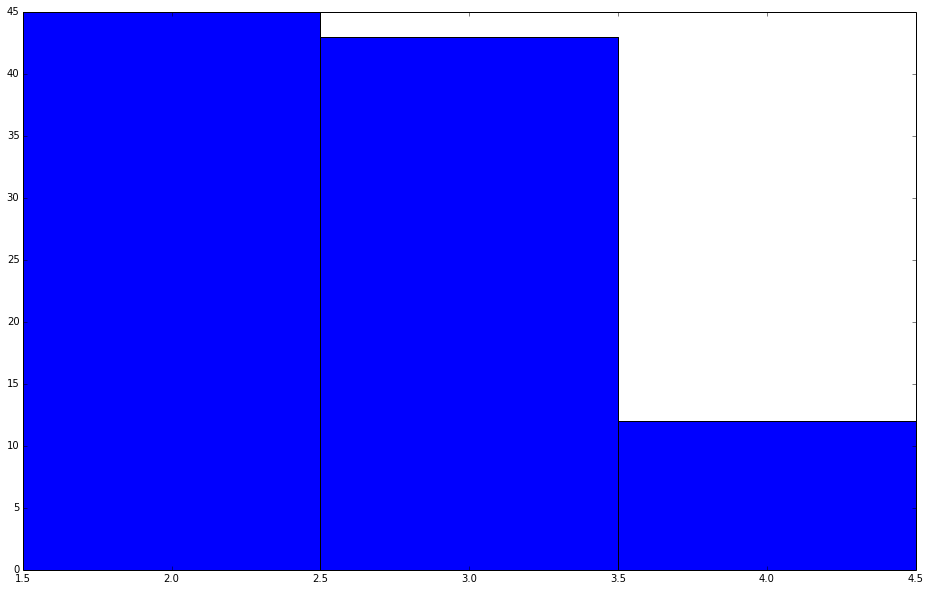

In [42]:
# Sample the parameters and draw a picture

samples = list()

for _ in range(100):

    v.infer(1000)

    cluster_memberships = v.sample('(list ' + ' '.join('(cluster_membership %d)' % index
                                                       for index in range(len(X))) + ')')
    cluster_numbers = np.unique(cluster_memberships)
    
    samples.append(len(cluster_numbers))
    
    
fig, ax = plt.subplots(figsize=(16, 10))
plt.clf()

plt.hist(samples, bins=(-1,0,1,2,3,4,5,6,7), align='right')

plt.show()

Saving 6.0 x 4.0 in image.


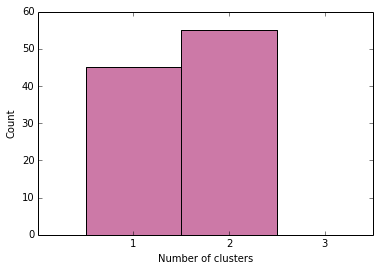

<ggplot: (8740020575389)>


In [49]:
# ggplot
# Relies on list of samples generated from for loop above

df = pd.DataFrame(samples,  columns=['cluster_num_count'])

# subtract 0.5 from all values to center
df['cluster_num_count'] = df['cluster_num_count']-0.5

p = ggplot(aes(x='cluster_num_count'), data=df)
p = (p + geom_histogram(binwidth=1, fill='#CC79A7') + theme_matplotlib() + xlim(0,(max(df['cluster_num_count'])+1)) + 
scale_x_continuous(breaks = range(1,10)) + xlab("Number of clusters") + ylab("Count"))



ggsave(p, "cluster_num_hist.pdf")
print(p)

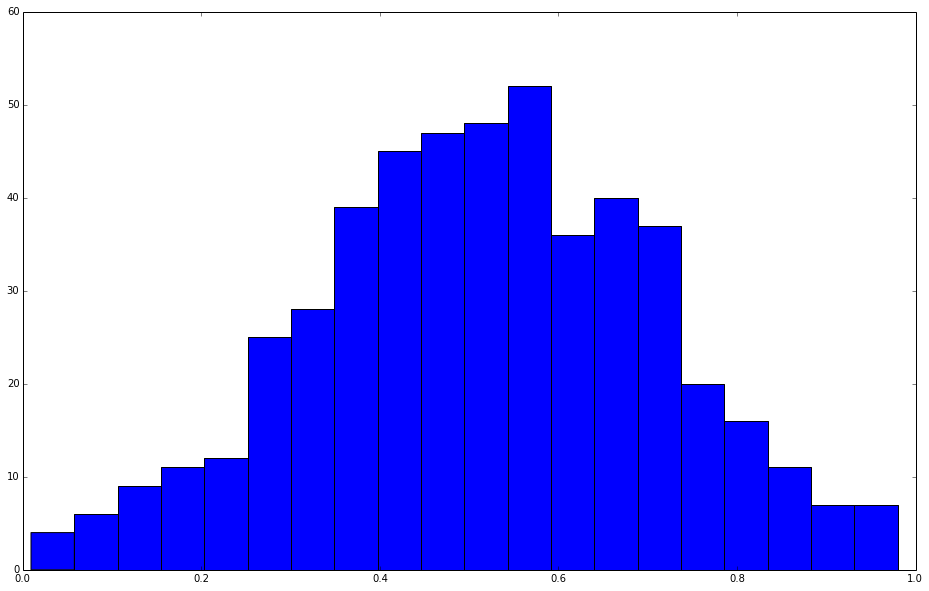

In [50]:
# Sample the parameters and draw a picture

samples = list()

for _ in range(500):

    v.infer(1000)
    
    param_beta = v.sample('beta')

    samples.append(param_beta)
    
fig, ax = plt.subplots(figsize=(16, 10))
plt.clf()

plt.hist(samples, bins=20)

plt.show()

stat_bin: binwidth defaulted to range/30.
    Use 'binwidth = x' to adjust this.
Saving 6.0 x 4.0 in image.


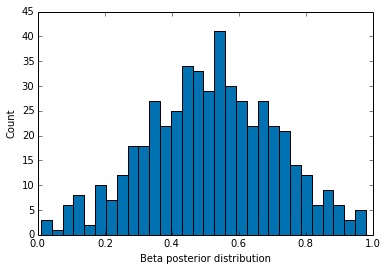

<ggplot: (8740020339489)>


In [52]:
# ggplot
# Relies on list of samples generated from for loop above

df = pd.DataFrame(samples,  columns=['Beta_posterior'])


p = ggplot(aes(x='Beta_posterior'), data=df)
p = (p + geom_histogram(fill='#0072B2') + theme_matplotlib() + 
xlab("Beta posterior distribution") + ylab("Count"))



ggsave(p, "beta_posterior_hist.pdf")
print(p)

In [61]:
# Sample cluster assignments - make a list of all the assignments for each sample

samples = list()

for _ in range(500):

    v.infer(5000)
    
    cluster_memberships = v.sample('(list ' + ' '.join('(cluster_membership %d)' % index
                                                   for index in range(len(X))) + ')')

    cluster_numbers = np.unique(cluster_memberships)

    canonical_cluster_memberships = np.zeros(len(cluster_memberships))
    
    for i, value in enumerate(cluster_numbers):
        canonical_cluster_memberships[cluster_memberships==value] = i
    
    cluster_memberships = canonical_cluster_memberships

    
    samples.append(cluster_memberships)
    
samples = np.array(samples)

# print(samples)

# print(samples.shape) # check to see whether array is correct shape

cluster_labels = np.unique(samples)

co_occurrence_matrix = np.zeros((samples.shape[1], samples.shape[1]))

for label in cluster_labels:
    co_occurrence_matrix += np.dot((samples.T == label) * 1, (samples == label) * 1)
    

# Reshape co-occurence_matrix by linkage
reshaped = sch.linkage(co_occurrence_matrix)
    
# print(co_occurrence_matrix)
# print(co_occurrence_matrix.shape)

# plt.clf()
# fig, ax = plt.subplots(figsize=(10, 10), dpi=100)

# ax.imshow(co_occurrence_matrix, interpolation='nearest') #interpolation changes fuzzyness. try 'none' or 'nearest'
# plt.show()

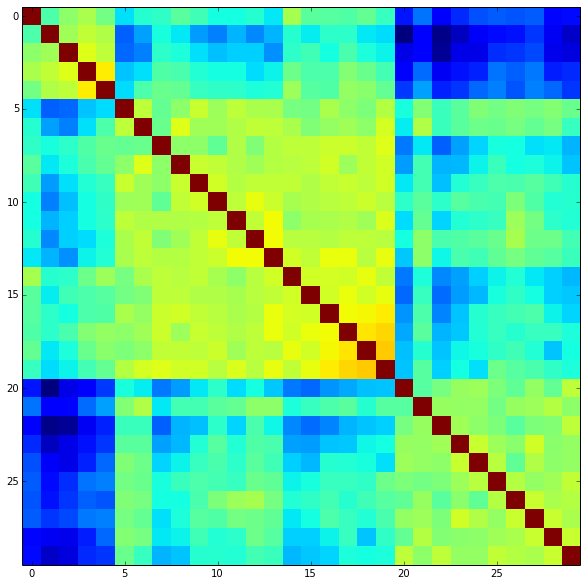

In [62]:
# Reshape co-occurence_matrix by linkage
linkage = sch.linkage(co_occurrence_matrix)
dendrogram_right = sch.dendrogram(linkage, orientation='right')
dendrogram = sch.dendrogram(linkage)
idx1 = dendrogram_right['leaves']
idx2 = dendrogram['leaves']
co_occurrence_matrix = co_occurrence_matrix[idx1,:]
co_occurrence_matrix = co_occurrence_matrix[:,idx2]

# Co-occurrence matrix figure

plt.clf()
fig, ax = plt.subplots(figsize=(10, 10), dpi=100)
ax.imshow(co_occurrence_matrix, interpolation='nearest') 
plt.savefig('co-occurrence.pdf') # this line has to come before plt.show
plt.show()

# print(reshaped)
# reshaped.shape

# plt.clf()
# fig, ax = plt.subplots(figsize=(10, 10), dpi=100)
# ax.imshow(reshaped, interpolation='nearest') 
# plt.savefig('co-occurrence.pdf') # this line has to come before plt.show
# plt.show()
